In [25]:
from sqlalchemy import (create_engine, Table, Column, Integer, String, MetaData, inspect)
import pandas as pd
import pymysql.cursors
import mysql.connector
import matplotlib.pyplot as plt
import numpy as np
import math
import nltk
#nltk.download("stopwords")
#nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from collections import Counter
%matplotlib inline

In [16]:
############ CONNECT TO THE DATABASE - windows/osx ############
# connection = pymysql.connect(host='localhost',
#                              user='root',
#                              password='Tianyu931211',#put your password for mysql server here.
#                              db='yelp_db',
#                              charset='utf8mb4',
#                              cursorclass=pymysql.cursors.DictCursor)

############ CONNECT TO THE DATABASE - RHEL ############
connection = mysql.connector.connect(
    user='root',
    password='root',
    host='127.0.0.1',
    port=3306,
    database='yelp_db')

raw_data=pd.read_sql('''
select business.city,business.id,review.text
FROM category inner join business on
business.id = category.business_id inner join review on business.id=review.business_id
where business.city ="Pittsburgh"''',connection).values


In [17]:
business_review={}

for i in raw_data:
    business_review[i[1]]=[""]
    
for i in raw_data:
    business_review[i[1]][0]=business_review[i[1]][0]+i[2]
    
stopWords = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')
wordsFiltered = []


In [18]:
tokenized_documents=[]

business_processed_review={} #contain business id and processed review data

for i in business_review:
    
    wordsFiltered=[]
    words=tokenizer.tokenize(business_review[i][0])
    
    for w in words:
        if w not in stopWords:
            wordsFiltered.append(w)

    for n in range(0,len(wordsFiltered)):
        wordsFiltered[n]=lemmatizer.lemmatize(wordsFiltered[n])
        
    business_processed_review[i]=wordsFiltered;
    
    
#corpus=set([item for key in business_processed_review for item in business_processed_review[key]])


In [19]:
idf={}


for i in business_processed_review:
    for word in set(business_processed_review[i]):
        if word in idf:
            idf[word]=idf[word]+1
        else:
            idf[word]=1

all_rev=len(business_processed_review)

for i in idf:
    idf[i]=math.log(all_rev/idf[i])

In [20]:
TFIDF={}

for i in business_processed_review:
    tfidf = {}
    length=len(business_processed_review[i])
    C=Counter(business_processed_review[i])
    
    for tkn in C:
        tf=C[tkn]/length
        tfidf[tkn]=idf[tkn]*tf
    TFIDF[i]=tfidf 

In [21]:
data=pd.DataFrame(TFIDF)
tfidf_data=data.fillna(0)

In [22]:
tfidf_data

,--cgVkbWTiga3OYTkymKqA,--cjBEbXMI2obtaRHNSFrA,--ujyvoQlwVoBgMYtADiLA,--wIGbLEhlpl_UeAIyDmZQ,-0nEqS3_A_nnUut4DrEPEg,-1PwcnMwaztBRKah7lrWBg,-1fwceFQw5NAemdPRrhP0g,-1xCh7Cocn6IwFzhELyohA,-3rvpkYkYD_N1IP4hSvD0A,-40RDS4F54qiGiEQUsZaXA,...,zuVd_9tIwTEYGouc8jGrjA,zuu87Wx0Sv2KCUzY_wGSKQ,zuz4w_uDWT5xC0EXOquhHQ,zxSfGIhK3hH3vVz_pS5eaA,zxgElV79Pgxq5vW8hhfnWg,zyRhwC9zs34LeYYfGc4gBA,zyZ5X_MyFurPTbSP_RoF0A,zyaRXoJkyNd_RPPtGrmMlA,zzBa0pQjM1gov00bXjYYXg,zzwhN7x37nyjP0ZM8oiHmw
0,0.0,0.000659,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.001324,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
00,0.0,0.000000,0.0,0.001368,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.001187,0.0,0.0,0.0,0.0
000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.002028,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
0000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
00000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
0000000001,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
0001,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
0002,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
0004,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
000IU,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [23]:
TFIDF_DATA=tfidf_data.T

In [24]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

maxClusters = 10
n = maxClusters+1
error = np.zeros(n)
error[0] = 0;
for k in range(1,n):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
    kmeans.fit_predict(TFIDF_DATA)
    error[k] = kmeans.inertia_
    print(k)

1
2
3
4
5
6
7
8
9
10


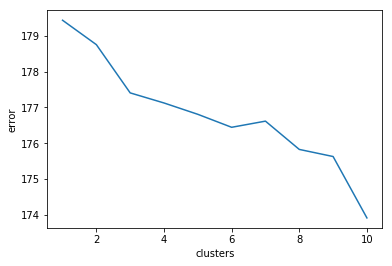

In [27]:
#plt.figure(1)
plt.plot(range(1,len(error)),error[1:])
plt.xlabel('clusters')
plt.ylabel('error')